## Fine gain notebook

In [1]:
#some imports
import time
from PIL import Image
import numpy as np
import pandas as pd
import pathlib
from picamera2 import Picamera2, Preview
import pprint
from ipywidgets import interact, interactive
from IPython.display import display
import matplotlib.pyplot as plt

import sys
sys.path.append("../common")
from driver_access import v4l2Ctrl
from config_parser import ConfigParser

i2c = v4l2Ctrl(sensor="mira050", printFunc=print)
def read_offset_clip():
    exp_val = i2c.rwReg(addr=0xE000, value=0, rw=1, flag=0) # WRITE bank sel 1
    exp_val_1 = i2c.rwReg(addr=0x0193, value= 0 >> 8 & 255, rw=0, flag=0) # READ registers 
    exp_val_2 = i2c.rwReg(addr=0x0194, value=0 & 255, rw=0, flag=0)


    
    print(f'offsetclip value in hex: {hex(exp_val_1)} {hex(exp_val_2)} ')
    print(f'offsetclip val in decimal: { 256* (exp_val_1) + (exp_val_2)}')
    pass

In [2]:
amount = 10 #numbers of pictures to capture per setting
gains = [1,2,4]
gains = np.arange(1,16,1)
exposures_us = [200] #np.arange(1000, 10000, 500, dtype=int) #start, stop, step - this must be an array type. can also be, [100,200,300,400] etc..
min_exposure = 100
bit_mode = 8

#select mode a few cells below.
TIFF = True
UPLOAD_FOLDER = pathlib.Path("./images")
UPLOAD_FOLDER.mkdir(parents=False, exist_ok=True)

temp_save_dir = UPLOAD_FOLDER
final_save_dir = UPLOAD_FOLDER

In [3]:
#view camera model
pprint.pprint(Picamera2.global_camera_info())  #before init ;
#print all sensor modes
with Picamera2() as picam2:
    modes = picam2.sensor_modes
    pprint.pprint(picam2.sensor_modes)

[0:06:42.142057087] [2543]  INFO Camera camera_manager.cpp:299 libcamera v0.0.4+22-923f5d70-dirty (2024-02-15T15:15:09+01:00)
[0:06:42.191669803] [2561]  WARN RPI raspberrypi.cpp:1357 Mismatch between Unicam and CamHelper for embedded data usage!
[0:06:42.192685648] [2561]  INFO RPI raspberrypi.cpp:1476 Registered camera /base/soc/i2c0mux/i2c@1/mira050@36 to Unicam device /dev/media4 and ISP device /dev/media3
[0:06:42.196808529] [2543]  INFO Camera camera_manager.cpp:299 libcamera v0.0.4+22-923f5d70-dirty (2024-02-15T15:15:09+01:00)
[0:06:42.208328713] [2564]  WARN RPI raspberrypi.cpp:1357 Mismatch between Unicam and CamHelper for embedded data usage!
[0:06:42.209303225] [2564]  INFO RPI raspberrypi.cpp:1476 Registered camera /base/soc/i2c0mux/i2c@1/mira050@36 to Unicam device /dev/media4 and ISP device /dev/media3
[0:06:42.224585515] [2543]  INFO Camera camera.cpp:1028 configuring streams: (0) 640x480-XBGR8888 (1) 576x768-SGRBG10_CSI2P
[0:06:42.224985568] [2564]  INFO RPI raspberrypi

[{'Id': '/base/soc/i2c0mux/i2c@1/mira050@36',
  'Location': 2,
  'Model': 'mira050',
  'Rotation': 0}]
[{'bit_depth': 10,
  'crop_limits': (0, 0, 576, 768),
  'exposure_limits': (132, 1000764, None),
  'format': SGRBG10_CSI2P,
  'fps': 120.08,
  'size': (576, 768),
  'unpacked': 'SGRBG10'},
 {'bit_depth': 12,
  'crop_limits': (0, 0, 576, 768),
  'exposure_limits': (132, 1000764, None),
  'format': SGRBG12_CSI2P,
  'fps': 60.0,
  'size': (576, 768),
  'unpacked': 'SGRBG12'},
 {'bit_depth': 8,
  'crop_limits': (0, 0, 576, 768),
  'exposure_limits': (132, 1000764, None),
  'format': SGRBG8,
  'fps': 120.08,
  'size': (576, 768),
  'unpacked': 'SGRBG8'}]


In [4]:
for mode in modes:
    if mode['bit_depth']==bit_mode:
        break
selected_mode=mode

In [5]:
#DARK CONDITIONS
bit_mode = selected_mode["bit_depth"]
im_data = pd.DataFrame()
print(f'you have chosen mode {selected_mode}')

with Picamera2() as picam2:
    preview_config = picam2.create_preview_configuration(main={"size": selected_mode["size"]},
        raw={"format": selected_mode["unpacked"],
            "size": selected_mode["size"],
        })
    picam2.configure(preview_config)

    picam2.start()

    for analog_gain in gains:
        for exposure in [min_exposure]:
        
            picam2.set_controls({"ExposureTime": exposure , "AnalogueGain": analog_gain})
            
            time.sleep(1)
            #raw = picam2.capture_buffer()
            #np.from_buffer
            
            size = selected_mode["size"]
        
            width = size[0]
            height = size[1]
            im_stack = []
            read_offset_clip()
            request = picam2.capture_request()
            
            for i in range(amount):
                if bit_mode == 8:
                    image = picam2.capture_array("raw").view(np.uint8)
                else:
                    image = picam2.capture_array("raw").view(np.uint16)
                im_stack.append(image[0:height, 0:width])
                if TIFF:
                    # save images    
                    pilim = Image.fromarray(image)
                    filename = str(f"{UPLOAD_FOLDER}/img_exposure{exposure}_gain{analog_gain}_DARK_{i}.tiff")
                    pilim.save(filename)
            request.release()
            # get & save images
            name = f'bm={bit_mode}_ag={analog_gain}_fc={amount}_exp={round(exposure, 1)}_dark.npz'
            temp_im_dir = UPLOAD_FOLDER
            temp_im_path = pathlib.Path(temp_im_dir / name)
            np.savez(str(temp_im_path), im_stack)
            mean_val = np.mean(im_stack)
            # add to image data
            temp = {'Analog Gain': [analog_gain],
                    'Bit Mode': [bit_mode],
                    'Exposure [ms]': [exposure],
                    'Frame Count': [amount],
                    'Illumination': [False],
                    'mean [DN]': [mean_val],
                    'Image Path_npz': [str(pathlib.Path(temp_im_dir / name))]}
            
            temp = pd.DataFrame.from_dict(temp)

            # concat raw to im_data
            im_data = pd.concat([im_data, temp], ignore_index=True).reset_index(drop=True)
    

you have chosen mode {'format': SGRBG8, 'unpacked': 'SGRBG8', 'bit_depth': 8, 'size': (576, 768), 'fps': 120.08, 'crop_limits': (0, 0, 576, 768), 'exposure_limits': (132, 1000764, None)}


[0:06:42.493543015] [2543]  INFO Camera camera_manager.cpp:299 libcamera v0.0.4+22-923f5d70-dirty (2024-02-15T15:15:09+01:00)
[0:06:42.505285254] [2568]  WARN RPI raspberrypi.cpp:1357 Mismatch between Unicam and CamHelper for embedded data usage!
[0:06:42.506274599] [2568]  INFO RPI raspberrypi.cpp:1476 Registered camera /base/soc/i2c0mux/i2c@1/mira050@36 to Unicam device /dev/media4 and ISP device /dev/media3
[0:06:42.511015754] [2543]  INFO Camera camera.cpp:1028 configuring streams: (0) 576x768-XBGR8888 (1) 576x768-SGRBG8
[0:06:42.511354418] [2568]  INFO RPI raspberrypi.cpp:851 Sensor: /base/soc/i2c0mux/i2c@1/mira050@36 - Selected sensor format: 576x768-SGRBG8_1X8 - Selected unicam format: 576x768-GRBG


offsetclip value in hex: 0x5 0xcc 
offsetclip val in decimal: 1484
offsetclip value in hex: 0x5 0xd6 
offsetclip val in decimal: 1494
offsetclip value in hex: 0x5 0xe0 
offsetclip val in decimal: 1504
offsetclip value in hex: 0x5 0xf6 
offsetclip val in decimal: 1526
offsetclip value in hex: 0x5 0xfa 
offsetclip val in decimal: 1530
offsetclip value in hex: 0x6 0x0 
offsetclip val in decimal: 1536
offsetclip value in hex: 0x6 0x4 
offsetclip val in decimal: 1540
offsetclip value in hex: 0x6 0xa 
offsetclip val in decimal: 1546
offsetclip value in hex: 0x6 0x8 
offsetclip val in decimal: 1544
offsetclip value in hex: 0x6 0xb 
offsetclip val in decimal: 1547
offsetclip value in hex: 0x6 0xd 
offsetclip val in decimal: 1549
offsetclip value in hex: 0x6 0x10 
offsetclip val in decimal: 1552
offsetclip value in hex: 0x6 0x12 
offsetclip val in decimal: 1554
offsetclip value in hex: 0x6 0x15 
offsetclip val in decimal: 1557
offsetclip value in hex: 0x6 0x18 
offsetclip val in decimal: 1560


In [6]:
im_data

,Analog Gain,Bit Mode,Exposure [ms],Frame Count,Illumination,mean [DN],Image Path_npz
0,1,8,100,10,False,16.004147,images/bm=8_ag=1_fc=10_exp=100_dark.npz
1,2,8,100,10,False,16.035343,images/bm=8_ag=2_fc=10_exp=100_dark.npz
2,3,8,100,10,False,15.937054,images/bm=8_ag=3_fc=10_exp=100_dark.npz
3,4,8,100,10,False,16.602748,images/bm=8_ag=4_fc=10_exp=100_dark.npz
4,5,8,100,10,False,16.655802,images/bm=8_ag=5_fc=10_exp=100_dark.npz
5,6,8,100,10,False,16.485900,images/bm=8_ag=6_fc=10_exp=100_dark.npz
6,7,8,100,10,False,16.404440,images/bm=8_ag=7_fc=10_exp=100_dark.npz
7,8,8,100,10,False,15.801352,images/bm=8_ag=8_fc=10_exp=100_dark.npz
8,9,8,100,10,False,17.330941,images/bm=8_ag=9_fc=10_exp=100_dark.npz
9,10,8,100,10,False,17.110253,images/bm=8_ag=10_fc=10_exp=100_dark.npz


<Axes: xlabel='Analog Gain', ylabel='mean [DN]'>

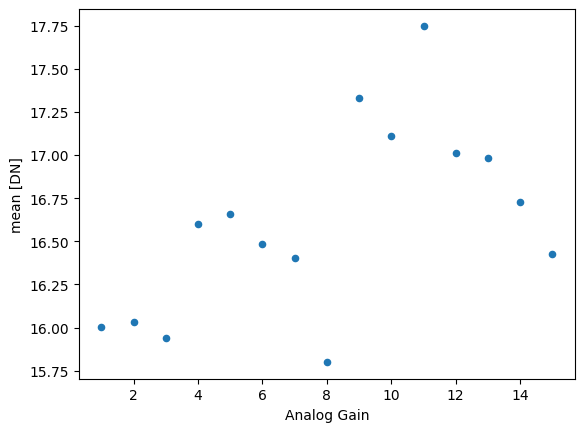

In [7]:
im_data.plot(kind = 'scatter', x = 'Analog Gain', y = 'mean [DN]')